# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a "specialized agent" for each task or domain and route tasks to the correct "expert". This means that each agent can become a sequence of LLM calls that chooses how to use a specific "tool".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using Burr.


In [1]:
# %pip install -U burr[start] langchain-community langchain-core langchain-experimental openai sf-hamilton[visualization]

In [1]:
# Environment variables
import os
# Make sure TAVILY_API_KEY & OPENAI_API_KEY are set
# os.environ['TAVILY_API_KEY'] = 'your_tavily_api_key' # get one at https://tavily.com
# os.environ['OPENAI_API_KEY'] = 'your_openai_api_key' # get one at https://platform.openai.com

In [2]:
# import everything that you'll need
import json
import pprint

from hamilton import driver
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL

from burr import core
from burr.core import ApplicationBuilder, State, action, default
from burr.lifecycle import PostRunStepHook
from burr.tracking import client as burr_tclient

# load hamilton plugin for notebooks
%load_ext hamilton.plugins.jupyter_magic

In [3]:
%%cell_to_module -m func_agent 
"""
Hamilton module that defines the pipeline for
hitting an LLM model and asking it what to do.
You can find this code in `func_agent.py` but we "inline" it here
to work in google colab.
"""

import inspect
import json
from typing import Callable

import openai
from langchain_core.utils.function_calling import convert_to_openai_function


def llm_client() -> openai.OpenAI:
    return openai.OpenAI()


def tool_names(tool_function_specs: list[dict]) -> list[str]:
    """Get the names of the tools from the tool function specs."""
    return [tool["function"]["name"] for tool in tool_function_specs]


def _langchain_tool_spec(tool: Callable) -> dict:
    """Converts a tool to a langchain tool spec."""
    t = convert_to_openai_function(tool)
    # print(t)
    return t


def _tool_function_spec(tool: Callable) -> dict:
    """Converts a python function into a specification for function calling.

    This is a little hacky. But it works.

    It takes a function, introspects it, and returns a spec.

    :param tool:
    :return:
    """
    # TODO: maybe just get people to wrap any external tool in a function
    # to make it clear what is going on.
    if hasattr(tool, "name") and hasattr(tool, "description") and hasattr(tool, "args_schema"):
        return {"type": "function", "function": _langchain_tool_spec(tool)}
    func_sig = inspect.signature(tool)
    name = tool.__name__
    docstring = inspect.getdoc(tool)
    doc_lines = docstring.split("\n") if docstring else []
    description = ""
    for line in doc_lines:
        stripped = line.strip()
        if stripped.startswith(":"):
            # we have reached the end of the description
            break
        description += stripped + "\n"
    description = description.strip()
    param_descriptions = {}
    for line in doc_lines:
        stripped = line.strip()
        if stripped.startswith(":param"):
            parts = stripped.split(" ", 2)
            param_name = parts[1].strip(":")
            param_description = parts[2]
            param_descriptions[param_name] = param_description
    parameters = func_sig.parameters
    func_parameters = {}
    required = []
    for param_name, param in parameters.items():
        param_type = param.annotation
        param_description = param_descriptions.get(param_name, "")
        if param_type == str:
            param_type = "string"
        elif param_type == int:
            param_type = "integer"
        elif param_type == float:
            param_type = "float"
        else:
            raise ValueError(f"Unsupported parameter type: {param_type}")
        func_parameters[param_name] = {
            "type": param_type,
            "description": param_description,
        }
        if param.default == inspect.Parameter.empty:
            required.append(param_name)
        else:
            func_parameters[param_name]["description"] += f" Defaults to {param.default}."

    return {
        "type": "function",
        "function": {
            "name": name,
            "description": description,
            "parameters": {
                "type": "object",
                "properties": func_parameters,
                "required": required,
            },
        },
    }


def tool_function_specs(tools: list[Callable]) -> list[dict]:
    """Converts a list of tools into a list of tool function specs."""
    return [_tool_function_spec(tool) for tool in tools]


def base_system_prompt(tool_names: list[str], system_message: str) -> str:
    """Creates the base system prompt for the pipeline."""
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress.\n\n"
        "If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with 'FINAL ANSWER' so the team knows to stop.\n\n"
        f"You have access to the following tools: {tool_names}.\n{system_message}\n\n"
        "Remember to prefix your response with 'FINAL ANSWER' if you or another assistant "
        "thinks the task is complete; assume the user can visualize the result."
    )


def message_history(base_system_prompt: str, user_query: str, messages: list[dict]) -> list[dict]:
    """Creates the message history for the LLM model.

    :param base_system_prompt:
    :param user_query:
    :param messages:
    :return:
    """
    base = [
        {"role": "system", "content": base_system_prompt},
        {"role": "user", "content": user_query},
    ]
    sanitized_messages = []
    for message in messages:
        message_copy = message.copy()
        if not isinstance(message_copy["content"], str) and message_copy["content"] is not None:
            message_copy["content"] = (
                json.dumps(message_copy["content"]) if message_copy["content"] else None
            )
        sanitized_messages.append(message_copy)
    return base + sanitized_messages


def llm_function_response(
    message_history: list[dict],
    tool_function_specs: list[dict],
    llm_client: openai.OpenAI,
) -> openai.types.chat.chat_completion.ChatCompletion:
    """Creates the function response from the LLM model for the given prompt & functions.

    :param message_history:
    :param tool_function_specs:
    :param llm_client:
    :return:
    """
    response = llm_client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=message_history,
        tools=tool_function_specs,
        tool_choice="auto",
    )
    return response


def llm_function_message(
    llm_function_response: openai.types.chat.chat_completion.ChatCompletion,
) -> dict:
    """Parses the LLM response message. Does extra parsing for tool invocations."""
    response_message = llm_function_response.choices[0].message
    if response_message.tool_calls:
        return {
            "role": response_message.role,
            "content": None,
            "tool_calls": [
                {
                    "id": t.id,
                    "type": "function",
                    "function": {"name": t.function.name, "arguments": t.function.arguments},
                }
                for t in response_message.tool_calls
            ],
        }
    return {
        "role": "assistant",
        "content": response_message.content,
    }


def parsed_tool_calls(
    llm_function_response: openai.types.chat.chat_completion.ChatCompletion,
) -> list[dict]:
    """Parses the tool calls from the LLM response message.

    :param llm_function_response: The response from the LLM model.
    :return: The parsed tool calls.
    """
    response_message = llm_function_response.choices[0].message
    tool_calls = response_message.tool_calls
    parsed_calls = []
    if tool_calls:
        for tool_call in tool_calls:
            func_call = {
                "id": tool_call.id,
                "function_name": tool_call.function.name,
                "function_args": tool_call.function.arguments,
            }
            parsed_calls.append(func_call)
    return parsed_calls


def executed_tool_calls(
    parsed_tool_calls: list[dict], tools: list[Callable]
) -> list[tuple[str, dict]]:
    """Executes the parsed tool calls.

    :param parsed_tool_calls: The parsed tool calls.
    :param tools: The tools to execute.
    :return: The results of the tool calls.
    """
    results = []
    for tool_call in parsed_tool_calls:
        tool_name = tool_call["function_name"]
        tool_args = tool_call["function_args"]
        tool_found = False
        for tool in tools:
            name = getattr(tool, "name", None)
            if name is None:
                name = tool.__name__
            if name == tool_name:
                tool_found = True
                kwargs = json.loads(tool_args)
                if hasattr(tool, "_run"):
                    result = tool._run(**kwargs)
                else:
                    result = tool(**kwargs)
                results.append(
                    (
                        tool_name,
                        {
                            "tool_call_id": tool_call["id"],
                            "role": "tool",
                            "name": tool_name,
                            "content": result,  # note: might not be a string.
                        },
                    )
                )
        if not tool_found:
            raise ValueError(f"Tool {tool_name} not found.")
    # TODO: do we add a sentinel if no tool call was required.
    return results


def _get_current_weather(location: str, unit: str = "fahrenheit") -> str:
    """Get the current weather in a given location

    Dummy function to simulate a weather API call.

    :param location: the location to get the weather for.
    :param unit: the unit of temperature to return. Celsius or Fahrenheit.
    :return: JSON string with the location and temperature, and unit.
    """
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": unit})
    elif "san francisco" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": unit})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": unit})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})


 # Define the tools that the agents will use

Here we construct the python objects that will be used as tools by our code.

In [4]:
repl = PythonREPL()
tavily_tool = TavilySearchResults(max_results=5)

def python_repl(code: str) -> dict:
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.

    :param code: string. The python code to execute.
    :return: the output
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return {"error": repr(e), "status": "error", "code": f"```python\n{code}\n```"}
    return {"status": "success", "code": f"```python\n{code}\n```", "Stdout": result}

# These are our tools that we will use in the application.
tools = [tavily_tool, python_repl]

# Define the agents
Our "agents" are effectively an execution of a series of LLM calls. 
In this example we use Hamilton to orchestrate this series of LLM calls.

For the source code and to see all the prompts used, see [func_agent.py](./func_agent.py). You'll see the structure of
this as the output of the next cell.

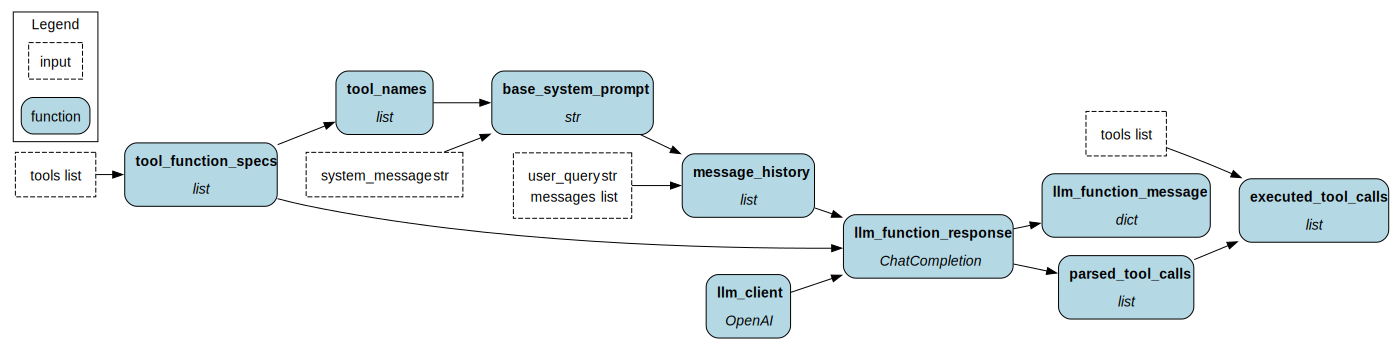

In [5]:
# The Agent that we'll use. Our agents here only differ by the system message passed in.
agent_dag = driver.Builder().with_modules(func_agent).build()
agent_dag

# Define the actions that map to agents
We now then create specific actions that map to the agents we need for this not example.
    
We want a "chart generator" action, that will map to an agent that can generate a chart based on provided context/data.

We want a "researcher" action, that will map to an agent that can search for information on a topic.

We then want a "tool_node" action, that will run a tool as specified by the prior action, i.e. agent.

In [7]:
@action(reads=["query", "messages"], writes=["messages"])
def chart_generator(state: State) -> tuple[dict, State]:
    """The chart generator action.

    :param state: state of the application
    :return: 
    """
    query = state["query"]
    result = agent_dag.execute(
        ["parsed_tool_calls", "llm_function_message"],
        inputs={
            "tools": [python_repl],
            "system_message": "Any charts you display will be visible by the user. When done say 'FINAL ANSWER'.",
            "user_query": query,
            "messages": state["messages"],
        },
    )
    new_message = result["llm_function_message"]
    parsed_tool_calls = result["parsed_tool_calls"]
    state = state.update(parsed_tool_calls=parsed_tool_calls)
    state = state.append(messages=new_message)
    state = state.update(sender="chart_generator")
    return result, state

@action(reads=["query", "messages"], writes=["messages"])
def researcher(state: State) -> tuple[dict, State]:
    """The researcher action.

    :param state: state of the application
    :return:
    """
    query = state["query"]
    result = agent_dag.execute(
        ["parsed_tool_calls", "llm_function_message"],
        inputs={
            "tools": [tavily_tool],
            "system_message": "You should provide accurate data for the chart generator to use. When done say 'FINAL ANSWER'.",
            "user_query": query,
            "messages": state["messages"],
        },
    )
    new_message = result["llm_function_message"]
    parsed_tool_calls = result["parsed_tool_calls"]
    state = state.update(parsed_tool_calls=parsed_tool_calls)
    state = state.append(messages=new_message)
    state = state.update(sender="researcher")
    return result, state


@action(reads=["messages", "parsed_tool_calls"], writes=["messages", "parsed_tool_calls"])
def tool_node(state: State) -> tuple[dict, State]:
    """Given a tool call, execute it and return the result."""
    new_messages = []
    parsed_tool_calls = state["parsed_tool_calls"]

    for tool_call in parsed_tool_calls:
        tool_name = tool_call["function_name"]
        tool_args = tool_call["function_args"]
        tool_found = False
        for tool in tools:
            name = getattr(tool, "name", None)
            if name is None:
                name = tool.__name__
            if name == tool_name:
                tool_found = True
                kwargs = json.loads(tool_args)
                # Execute the tool!
                if hasattr(tool, "_run"):
                    result = tool._run(**kwargs)
                else:
                    result = tool(**kwargs)
                new_messages.append(
                    {
                        "tool_call_id": tool_call["id"],
                        "role": "tool",
                        "name": tool_name,
                        "content": result,
                    }
                )
        if not tool_found:
            raise ValueError(f"Tool {tool_name} not found.")

    for tool_result in new_messages:
        state = state.append(messages=tool_result)
    state = state.update(parsed_tool_calls=[])
    # We return a list, because this will get added to the existing list
    return {"messages": new_messages}, state

@action(reads=[], writes=[])
def terminal_step(state: State) -> tuple[dict, State]:
    """Terminal step we have here that does nothing, but it could"""
    return {}, state

# Define the Graph / Application
With Burr we need to now construct our application, i.e. graph, by:

1. Defining what the actions are and how to transition between them.
2. Defining the initial state of the application. In our example this means we need to provide a "query" for the agents to work on.

Because Burr comes with built in persistence, we can also load a prior execution and continue from 
any point in its history by specifying a `app_instance_id` and `sequence_number` when building the application.

In [11]:
# Adjust these if you want to load a prior execution
app_instance_id = None
sequence_id = None
project_name = "demo_hamilton-multi-agent-v1"

# CHANGE THIS IF YOU WANT SOMETHING DIFFERENT!
default_query = ("Fetch the UK's GDP over the past 5 years, then draw a line graph of it. "
                 "Once the python code has been written and the graph drawn, the task is complete.")

In [14]:
# Determine initial state and entry point
def default_state_and_entry_point() -> tuple[dict, str]:
    """Returns the default state and entry point for the application."""
    return {
        "messages": [],
        "query": default_query,
        "sender": "",
        "parsed_tool_calls": [],
    }, "researcher"

if app_instance_id:
    tracker = burr_tclient.LocalTrackingClient(project_name)
    persisted_state = tracker.load("demo", app_id=app_instance_id, sequence_no=sequence_id)
    if not persisted_state:
        print(f"Warning: No persisted state found for app_id {app_instance_id}.")
        state, entry_point = default_state_and_entry_point()
    else:
        state = persisted_state["state"]
        entry_point = persisted_state["position"]
else:
    state, entry_point = default_state_and_entry_point()

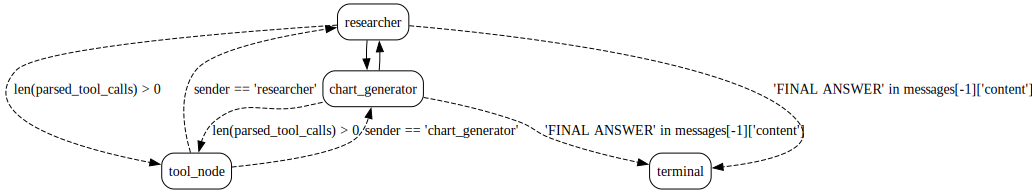

In [13]:
# Build the application 
def build_application(state: dict, entry_point: str):
    _app = (
        ApplicationBuilder()
        # set the actions
        .with_actions(
            researcher=researcher,
            chart_generator=chart_generator,
            tool_node=tool_node,
            terminal=terminal_step,
        )
        # set the transitions
        .with_transitions(
            ("researcher", "tool_node", core.expr("len(parsed_tool_calls) > 0")),
            (
                "researcher",
                "terminal",
                core.expr("'FINAL ANSWER' in messages[-1]['content']"),
            ),
            ("researcher", "chart_generator", default),
            ("chart_generator", "tool_node", core.expr("len(parsed_tool_calls) > 0")),
            (
                "chart_generator",
                "terminal",
                core.expr("'FINAL ANSWER' in messages[-1]['content']"),
            ),
            ("chart_generator", "researcher", default),
            ("tool_node", "researcher", core.expr("sender == 'researcher'")),
            ("tool_node", "chart_generator", core.expr("sender == 'chart_generator'")),
        )
        # set a few other things
        .with_identifiers(partition_key="demo")
        .with_state(**state)
        .with_entrypoint(entry_point)
        .with_tracker(project=project_name)
        .build()
    )
    return _app
app = build_application(state, entry_point)
app.visualize(
    output_file_path="statemachine", include_conditions=True, format="png"
)

# open up the Burr UI to trace the execution
In another terminal run:
```bash
burr
```
and then open up the browser to [http://localhost:7241](http://localhost:7241) to see the execution of the application when you execute `run()` below.

Python REPL can execute arbitrary code. Use with caution.


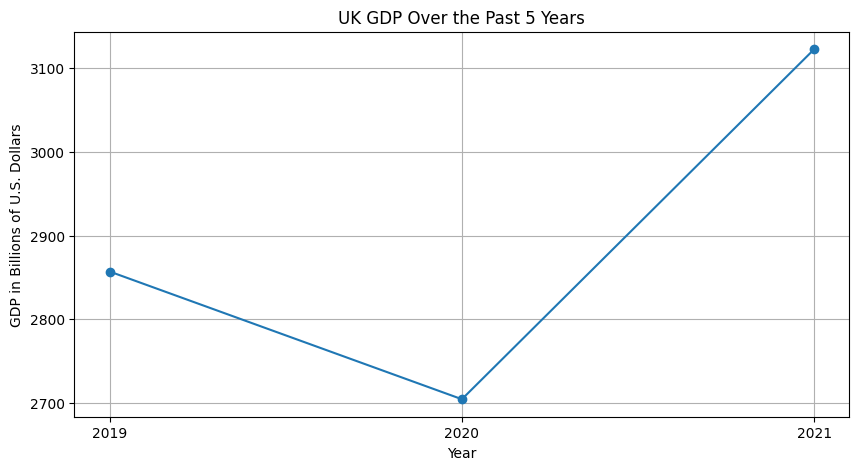

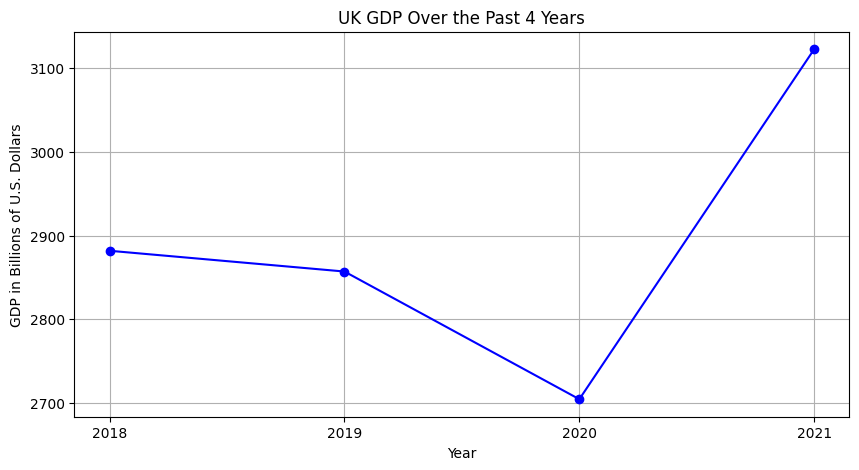

(terminal: {} -> {},
 {},
 {'messages': [{'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_eZDxApbzASyhLjam69JfqcQq', 'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': '{"query":"UK GDP over the past 5 years"}'}}]}, {'tool_call_id': 'call_eZDxApbzASyhLjam69JfqcQq', 'role': 'tool', 'name': 'tavily_search_results_json', 'content': [{'url': 'https://www.ons.gov.uk/economy/grossdomesticproductgdp', 'content': 'Quarter on Quarter growth: CVM SA %\nChained Volume Measures (CVM)\nGross Domestic Product: q-on-q4 growth rate CVM SA %\nChained Volume Measures (CVM)\nGross Domestic Product at market prices: Current price: Seasonally adjusted £m\nCurrent Prices (CP)\nGross Domestic Product: quarter on quarter growth rate: CP SA %\nCurrent Prices (CP)\nGross Domestic Product: q-on-q4 growth quarter growth: CP SA %\nCurrent Prices (CP)\nDatasets related to Gross Domestic Product (GDP)\n A roundup of the latest data and trends on the economy, busines

In [11]:
# this will run until completion.
last_action, last_result, last_state = app.run(halt_after=["terminal"])

In [ ]:
pprint.pprint(last_state)

# Change the Query!
Right now we provide the starting query as state. So we just create a new application by adjusting 
the initial state we provide.

In [16]:
# Let's change the query
state["query"] = ("Fetch the USA's GDP over the past 5 years, then draw a line graph of it. "
                 "Once the python code has been written and the graph drawn, the task is complete.")
app2 = build_application(state, entry_point)

Python REPL can execute arbitrary code. Use with caution.


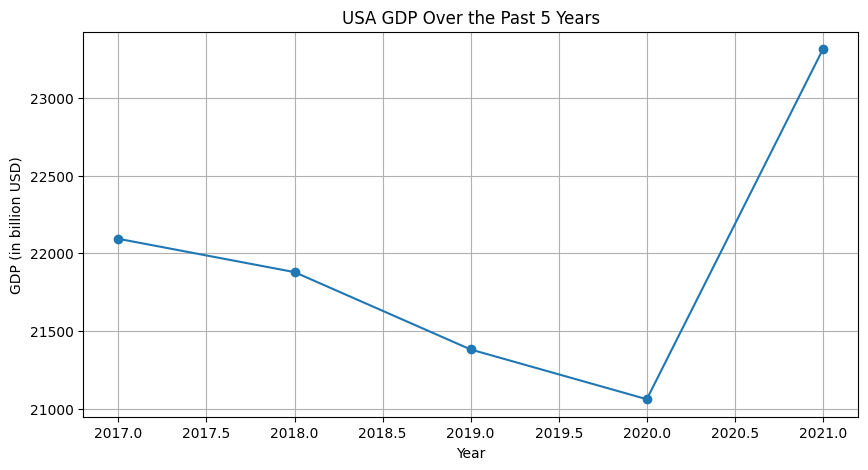

In [17]:
# this will run until completion.
last_action, last_result, last_state = app2.run(halt_after=["terminal"])

In [21]:
pprint.pprint(last_state)

{'messages': [{'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_DcmKJnsbk0w4QF1cwPys8qTQ', 'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': '{"query":"USA GDP over the past 5 years"}'}}]}, {'tool_call_id': 'call_DcmKJnsbk0w4QF1cwPys8qTQ', 'role': 'tool', 'name': 'tavily_search_results_json', 'content': [{'url': 'https://www.thebalancemoney.com/us-gdp-by-year-3305543', 'content': "U.S. GDP by Year, Compared to Recessions and Events\nThe Strange Ups and Downs of the U.S. Economy Since 1929\nThe Balance / Julie Bang\nU.S. gross domestic product (GDP) by year is a good overview of economic growth in the United States. Rebasing changes the reference year (or base year) for the real (chained dollar and quantity index) estimates and price indexes and expresses GDP and other NIPA aggregates in terms of the prices of one year. You can compare the GDP by year to fiscal and monetary policies to get a complete picture of what works and what doesn